In [31]:
import geopandas as gpd
from math import radians, sin, cos, sqrt, atan2

# Melbourne CBD coordinates
melb_lat, melb_lon = -37.8136, 144.9631

# Haversine formula for distance (km) - ChatGpt generated
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

lga_gdf = gpd.read_file("LGA_2021_AUST_GDA2020.shp")

#Victorian LGAs
vic_gdf = lga_gdf[lga_gdf["STE_NAME21"] == "Victoria"].copy()

vic_gdf["centroid"] = vic_gdf.geometry.centroid
vic_gdf["lat"] = vic_gdf.centroid.y
vic_gdf["lon"] = vic_gdf.centroid.x

# 4. Calculate distance from Melbourne CBD
vic_gdf["dist_from_cbd_km"] = vic_gdf.apply(
    lambda row: haversine(melb_lat, melb_lon, row["lat"], row["lon"]),
    axis=1
)

# 5. Save to CSV for later use
vic_gdf[["LGA_NAME21", "lat", "lon", "dist_from_cbd_km"]].to_csv("vic_lga_with_distances.csv", index=False)

print(vic_gdf[["LGA_NAME21", "dist_from_cbd_km"]])


                                 LGA_NAME21  dist_from_cbd_km
131                                  Alpine        207.382751
132                                  Ararat        190.457753
133                                Ballarat        109.968479
134                                 Banyule         14.163516
135                              Bass Coast         93.033818
..                                      ...               ...
208                            Yarra Ranges         65.455103
209                            Yarriambiack        303.767696
210                      Unincorporated Vic         82.139375
211                 No usual address (Vic.)               NaN
212  Migratory - Offshore - Shipping (Vic.)               NaN

[82 rows x 2 columns]


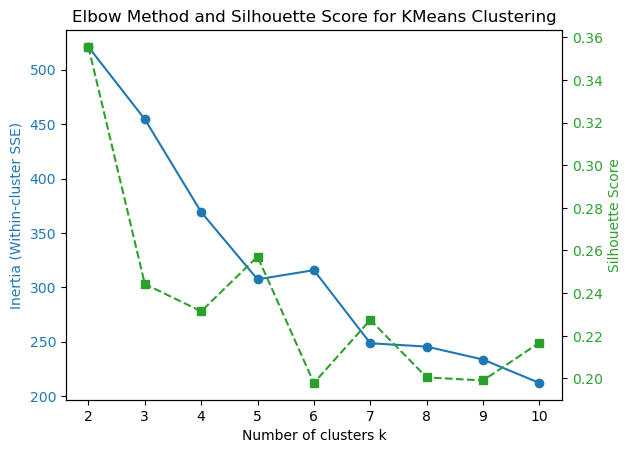

In [33]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
df = pd.read_excel("Quarterly Rents by LGA.xlsx")

features = [
    "rent_growth", "absolute_rent_change", "Average_annual_growth_rate",
    "median_hh_income", "average_hh_size", "income_below_400", "income_above_1500",
    "median_age", "total_unemployment", "birthplace_australia", "distance_to_cbd"
]

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
sil_scores = []
K_range = range(2, 11)  #2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia (Within-cluster SSE)', color=color)
ax1.plot(K_range, inertia, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, sil_scores, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method and Silhouette Score for KMeans Clustering')
plt.show()


In [35]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


print(df[['LGA', 'cluster']].sort_values('cluster'))

             LGA  cluster
67  Yarra Ranges        0
45       Latrobe        0
43       Baw Baw        0
41       Wodonga        0
35      Mitchell        0
..           ...      ...
33        Indigo        4
34     Mansfield        4
36         Moira        4
23    Gannawarra        4
38   Strathbogie        4

[78 rows x 2 columns]


In [17]:
unique_names = df.loc[df['cluster'] == 3, 'LGA'].unique()
print(unique_names)

['Surf Coast' 'Banyule' 'Darebin' 'Hobsons Bay' 'Maribyrnong' 'Melbourne'
 'Moonee Valley' 'Nillumbik' 'Yarra' 'Boroondara' 'Bayside' 'Glen Eira'
 'Kingston' 'Port Phillip' 'Stonnington']


In [37]:
df[["LGA","cluster"]].to_csv("cluster_info.csv", index=False)

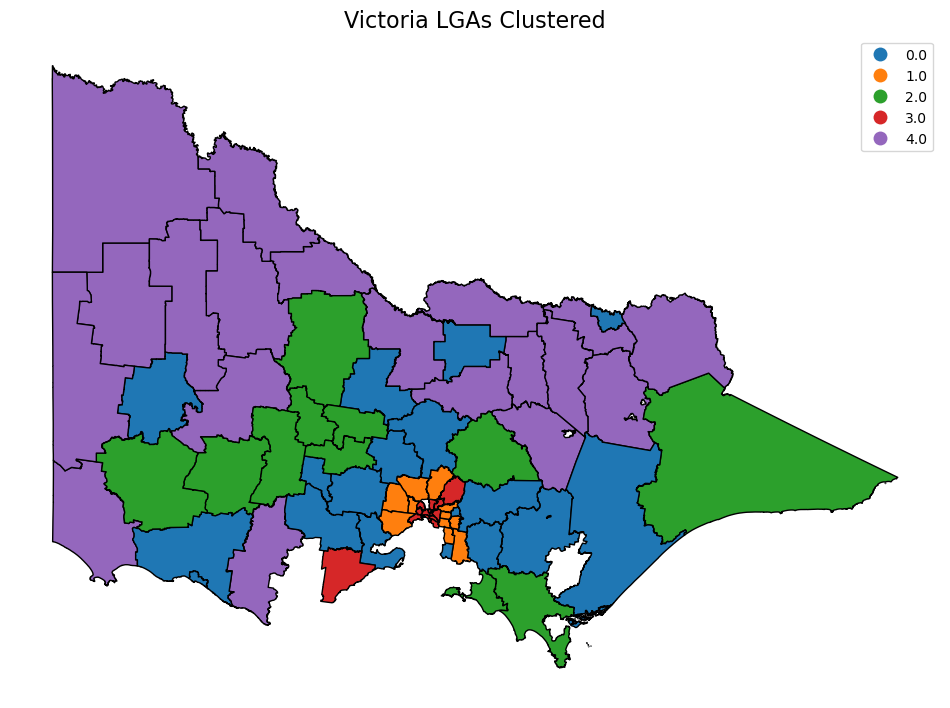

In [39]:
import matplotlib.colors as mcolors

lga_gdf = gpd.read_file("LGA_2021_AUST_GDA2020.shp")

vic_gdf = lga_gdf[lga_gdf["STE_NAME21"] == "Victoria"].copy()


cluster_df = pd.read_csv("cluster_info.csv")  # Your file with 'LGA' and 'cluster' columns


vic_gdf = vic_gdf.merge(cluster_df[['LGA', 'cluster']], left_on='LGA_NAME21', right_on='LGA', how='left')

vic_gdf['cluster'] = vic_gdf['cluster'].astype('category')
cmap = mcolors.ListedColormap(plt.get_cmap('tab10').colors[:5])
# 5. Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
vic_gdf.plot(column='cluster', cmap=cmap, categorical=True, legend=True, ax=ax, edgecolor='black')

ax.set_title('Victoria LGAs Clustered', fontsize=16)
ax.axis('off')

plt.show()


In [41]:
cluster_summary = df.groupby('cluster')[features].mean().round(2)
print(cluster_summary)

         rent_growth  absolute_rent_change  Average_annual_growth_rate  \
cluster                                                                  
0               0.74                199.95                        0.06   
1               0.64                210.55                        0.05   
2               0.64                150.58                        0.05   
3               0.52                191.60                        0.04   
4               0.99                193.15                        0.07   

         median_hh_income  average_hh_size  income_below_400  \
cluster                                                        
0                 1600.85             2.51              0.24   
1                 1800.36             2.89              0.29   
2                 1202.08             2.19              0.25   
3                 2102.53             2.37              0.22   
4                 1242.25             2.27              0.25   

         income_above_1500  medi

In [43]:
## metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)

print("KMeans Metrics:")
print(f"Silhouette Score: {sil_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {ch_kmeans:.3f}")

KMeans Metrics:
Silhouette Score: 0.257
Calinski-Harabasz Index: 32.714
